In [43]:
import torchvision, torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from torchvision import transforms
from tqdm import tqdm_notebook
import sklearn
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.color import rgb2gray
from sklearn.datasets import fetch_lfw_people
%matplotlib inline

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### MNIST part

In [4]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor()
])

In [5]:
mnist_train_dataset = torchvision.datasets.MNIST('../datasets/', train=True, transform=transform, download=True)
mnist_val_dataset = torchvision.datasets.MNIST('../datasets/', train=False, transform=transform, download=True)

In [6]:
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_dataset, shuffle=True, batch_size=100, num_workers=2)
mnist_val_loader = torch.utils.data.DataLoader(dataset=mnist_val_dataset, batch_size=30, num_workers=2)

In [7]:
def compute_loss(model, X_batch, y_batch):
    X_batch = Variable(torch.cuda.FloatTensor(X_batch))
    y_batch = Variable(torch.cuda.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [8]:
def train_evaluate_model(model, train_loader, test_loader, num_epochs = 10, batch_size = 100):
    model.cuda()  
    
    opt = torch.optim.Adam(model.parameters())

    train_loss = []
    val_accuracy = []
    

    for epoch in tqdm_notebook(range(num_epochs)):
        start_time = time.time()
        
        model.train(True) 
        for X_batch, y_batch in train_loader:
            loss = compute_loss(model, X_batch.cuda(), y_batch.cuda())
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.item())

        model.train(False) 
        for X_batch, y_batch in test_loader:
            logits = model(Variable(torch.FloatTensor(X_batch).cuda()))
            y_pred = logits.argmax(1).cpu().data.numpy()
            y_batch = y_batch.cpu().numpy()  
            cur_acc = (y_batch == y_pred).mean()
            val_accuracy.append(cur_acc)
            
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_loader.dataset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(test_loader.dataset) // batch_size :]) * 100))

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### Fully-Connected Net on MNIST

In [14]:
fc = nn.Sequential(*[
    Flatten(),
    nn.Linear(784, 350),
    nn.ReLU(),
    nn.Linear(350, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
]).cuda()

In [16]:
train_evaluate_model(fc, mnist_train_loader, mnist_val_loader)

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

Epoch 1 of 5 took 3.967s
  training loss (in-iteration): 	0.036587
  validation accuracy: 			98.00 %
Epoch 2 of 5 took 3.958s
  training loss (in-iteration): 	0.025396
  validation accuracy: 			98.00 %
Epoch 3 of 5 took 3.948s
  training loss (in-iteration): 	0.021493
  validation accuracy: 			99.00 %
Epoch 4 of 5 took 3.927s
  training loss (in-iteration): 	0.016419
  validation accuracy: 			98.00 %
Epoch 5 of 5 took 3.969s
  training loss (in-iteration): 	0.014921
  validation accuracy: 			98.00 %



In [17]:
torch.save(fc.state_dict(), './mnist_pretrained.pt')

In [18]:
fc.load_state_dict(torch.load('./mnist_pretrained.pt'))

In [19]:
def compute_loss_attack_mnist(model, X_batch, y_batch):
    logits = model(X_batch.cuda())
    return F.cross_entropy(logits, y_batch.cuda()).mean(), X_batch

In [20]:
def attack_fastgrad_mnist(model, input_image, target_class, EPS=0.1):
    x = torch.tensor(input_image.unsqueeze(0), requires_grad=True)
    y = torch.tensor([target_class])
    
    initial_prediction = model(x.cuda()).argmax(1).item()
      
    loss, _ = compute_loss_attack_mnist(model, x, y)
    loss.backward()

    gradient = torch.sign(x.grad.data)
    
    adversarial_example = x.data + EPS * gradient
    adversarial_prediction = model(adversarial_example.cuda()).argmax(1).item()
    
    return EPS * gradient

In [21]:
val_accuracy = []

for X_batch, y_batch in mnist_val_loader:
    logits = fc(Variable(torch.FloatTensor(X_batch).cuda()))
    y_pred = logits.argmax(1).cpu().data.numpy()
    y_batch = y_batch.cpu().numpy()  
    cur_acc = (y_batch == y_pred).mean()
    val_accuracy.append(cur_acc)
    
initial_fc = np.mean(val_accuracy)

In [22]:
noise_fc_accuracy = []
batch_size = 1
mnist_val_loader = data_utils.DataLoader(mnist_val_dataset, batch_size=batch_size, shuffle=False)

for EPS in tqdm_notebook(np.arange(0, 0.105, 0.005)):
    val_accuracy = []
    for (i, batch) in enumerate(mnist_val_loader):            
        noise = attack_fastgrad_mnist(fc, batch[0], batch[1], EPS = EPS)
        batch[0] = batch[0].squeeze() + noise.squeeze()
        logits = fc(Variable(torch.FloatTensor(batch[0].unsqueeze(0))).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred).mean()
        val_accuracy.append(cur_acc)
  
    noise_fc_accuracy.append(np.mean(val_accuracy))

HBox(children=(IntProgress(value=0, max=21), HTML(value=u'')))

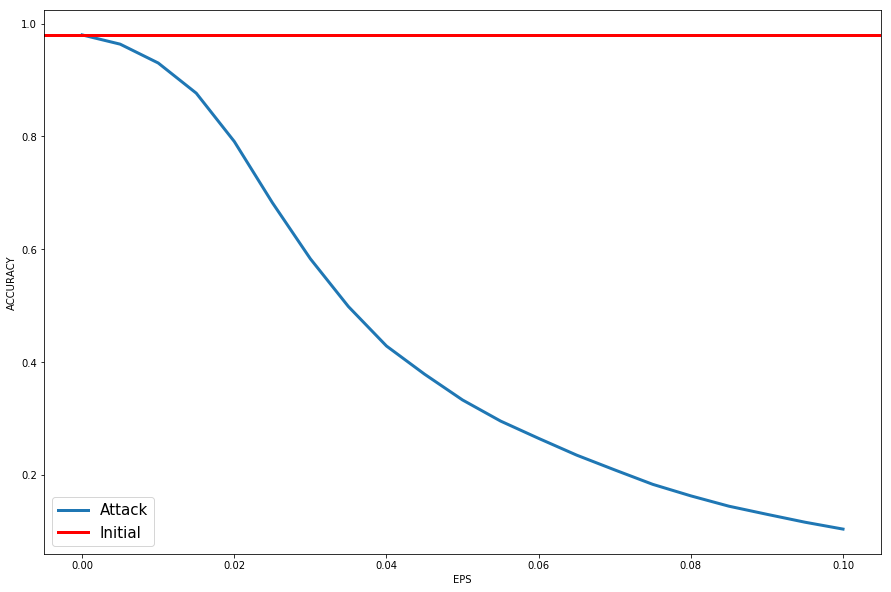

In [23]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 0.105, 0.005), noise_fc_accuracy, linewidth=3)
plt.axhline(y=initial_fc, color='r', linewidth=3)
plt.legend(["Attack", "Initial"], fontsize = 15)
plt.xlabel("EPS")
plt.ylabel("ACCURACY")
plt.show()

In [111]:
def attack_optim_mnist(model, input_image, true_class, target_class, EPS = 1, max_iter=1000, threshold=10):
    
    par = nn.Parameter(torch.zeros_like(input_image).uniform_())
    optimizer = torch.optim.Adam([par], lr=0.008)

    x = torch.tensor(input_image, requires_grad=True)
    y_target = torch.tensor([target_class], requires_grad=True)
    y_true = torch.tensor([true_class])
    initial_prediction = model(x.cuda()).argmax(1).item()
    cur_example = par.data

    for i in range(max_iter):
        optimizer.zero_grad()
        loss, _ = compute_loss_attack_mnist(model, torch.clamp(x + par, 0, 1), y_target)
        regularization = par.pow(2).sum().cuda()
        loss += EPS*regularization
        loss.backward()
        optimizer.step()
        adv_prediction = model((x + par).cuda()).argmax(1).item()

        if adv_prediction == y_target:
            cur_example = par.data

        if regularization < threshold:
            break
               
    return cur_example

In [151]:
batch_size = 1
mnist_val_loader = data_utils.DataLoader(mnist_val_dataset, batch_size=batch_size, shuffle=False)

val_opt_accuracy = []
for (i, batch) in tqdm_notebook(enumerate(mnist_val_loader)):  
    if i < 1000:
        noise = attack_optim_mnist(fc, batch[0], batch[1], target_class = 9 - batch[1].numpy()[0])
        batch[0] = batch[0].squeeze() + noise.squeeze()
        logits = fc(Variable(torch.FloatTensor(batch[0].unsqueeze(0))).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred)
        val_opt_accuracy.append(cur_acc)

noise_opt_accuracy = np.mean(val_opt_accuracy)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [25]:
def print_before_after_fast_mnist(model, number, EPS):
    noise = attack_fastgrad_mnist(model, mnist_val_dataset[number][0], 
                               mnist_val_dataset[number][1], EPS=EPS).squeeze()
    new_image = mnist_val_dataset[number][0].reshape((28, 28)) + noise
    
    logits = model(torch.tensor(new_image.unsqueeze(0)).cuda())
    y_pred = logits.argmax(1).cpu().data.numpy()
    
    print "Class before non-targeted attack", mnist_val_dataset[number][1].numpy().item()
    print "Class after non-targeted attack", y_pred[0]
    print "Epsilon is", EPS
    
    fig = plt.figure(figsize=(10, 15))
    plt.subplot(121)
    plt.imshow(mnist_val_dataset[number][0].reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.subplot(122)
    plt.imshow(new_image.reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.show()

Class before non-targeted attack 9
Class after non-targeted attack 7
Epsilon is 0.1


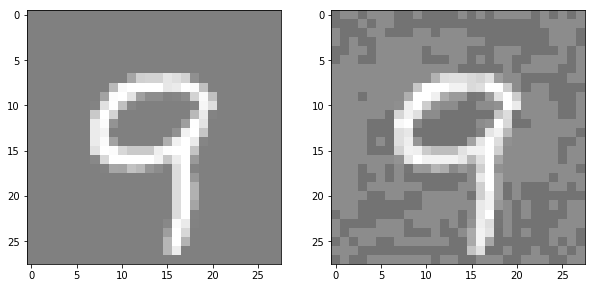

In [27]:
print_before_after_fast_mnist(fc, 105, EPS=0.1)

In [166]:
def print_before_after_target_mnist(model, number):
    noise = attack_optim_mnist(model, mnist_val_dataset[number][0], 
                               mnist_val_dataset[number][1], 9 - mnist_val_dataset[number][1].numpy()).squeeze()
    new_image = mnist_val_dataset[number][0].reshape((28, 28)) + noise
    
    logits = model(torch.tensor(new_image.unsqueeze(0)).cuda())
    y_pred = logits.argmax(1).cpu().data.numpy()
    
    print "Class before targeted attack", mnist_val_dataset[number][1].numpy().item()
    print "Class after targeted attack", y_pred[0]
    
    fig = plt.figure(figsize=(10, 15))
    plt.subplot(121)
    plt.imshow(mnist_val_dataset[number][0].reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.subplot(122)
    plt.imshow(new_image.reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.show()

Class before targeted attack 2
Class after targeted attack 7


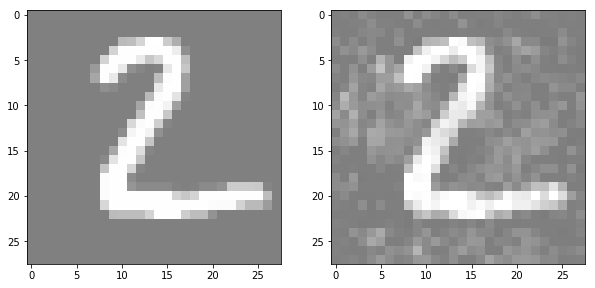

In [170]:
print_before_after_target_mnist(fc, 1)

## Convolutional Net on MNIST

In [28]:
convnet = nn.Sequential()

convnet.add_module('conv1', nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 3))
convnet.add_module('relu1', nn.ReLU(inplace = True))

convnet.add_module('conv2', nn.Conv2d(in_channels = 4, out_channels = 16, kernel_size = 3))
convnet.add_module('relu2', nn.ReLU(inplace = True))

convnet.add_module('flat', Flatten())

convnet.add_module('dense1', nn.Linear(in_features = 9216, out_features = 256))
convnet.add_module('relu3', nn.ReLU(inplace = True))

convnet.add_module('dense2', nn.Linear(in_features = 256, out_features = 10))

convnet.add_module('sm', nn.Softmax())

In [29]:
train_evaluate_model(convnet, mnist_train_loader, mnist_val_loader)

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 of 10 took 5.179s
  training loss (in-iteration): 	1.651945
  validation accuracy: 			94.00 %
Epoch 2 of 10 took 5.118s
  training loss (in-iteration): 	1.501248
  validation accuracy: 			97.00 %
Epoch 3 of 10 took 5.086s
  training loss (in-iteration): 	1.487054
  validation accuracy: 			97.00 %
Epoch 4 of 10 took 5.080s
  training loss (in-iteration): 	1.482240
  validation accuracy: 			97.00 %
Epoch 5 of 10 took 5.154s
  training loss (in-iteration): 	1.477718
  validation accuracy: 			98.00 %
Epoch 6 of 10 took 5.094s
  training loss (in-iteration): 	1.475837
  validation accuracy: 			98.00 %
Epoch 7 of 10 took 5.114s
  training loss (in-iteration): 	1.474343
  validation accuracy: 			95.00 %
Epoch 8 of 10 took 5.193s
  training loss (in-iteration): 	1.472908
  validation accuracy: 			100.00 %
Epoch 9 of 10 took 5.134s
  training loss (in-iteration): 	1.470943
  validation accuracy: 			100.00 %
Epoch 10 of 10 took 5.140s
  training loss (in-iteration): 	1.470270
  validatio

In [31]:
noise_accuracy_convnet = []

for EPS in tqdm_notebook(np.arange(0, 0.105, 0.005)):
    val_accuracy = []
    for (i, batch) in enumerate(mnist_val_loader):            
        for j in range(len(batch[0])):
            noise = attack_fastgrad_mnist(convnet, batch[0][j], batch[1][j], EPS = EPS)
            batch[0][j]= batch[0][j].squeeze() + noise.squeeze()

        logits = convnet(Variable(torch.FloatTensor(batch[0]).cuda()))
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred).mean()
        val_accuracy.append(cur_acc)

        
    noise_accuracy_convnet.append(np.mean(val_accuracy))

HBox(children=(IntProgress(value=0, max=21), HTML(value=u'')))

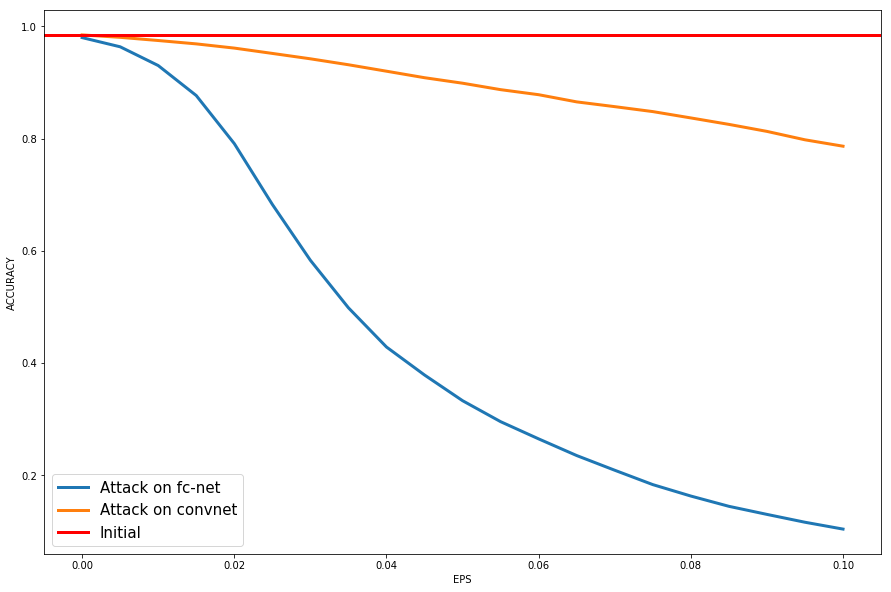

In [35]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 0.105, 0.005), noise_fc_accuracy, linewidth=3)
plt.plot(np.arange(0, 0.105, 0.005), noise_accuracy_convnet, linewidth=3)
plt.axhline(y=noise_accuracy_convnet[0], color='r', linewidth=3)
plt.legend(["Attack on fc-net", "Attack on convnet", "Initial"], fontsize = 15)
plt.xlabel("EPS")
plt.ylabel("ACCURACY")
plt.show()

In [157]:
def print_before_after_fast_Cmnist(model, number, EPS):
    noise = attack_fastgrad_mnist(model, mnist_val_dataset[number][0], 
                               mnist_val_dataset[number][1], EPS=EPS).squeeze()
    new_image = mnist_val_dataset[number][0].reshape((-1, 1, 28, 28)) + noise

    logits = model(Variable(torch.FloatTensor(new_image).cuda()))
    y_pred = logits.argmax(1).cpu().data.numpy()
    
    print "Class before non-targeted attack is", mnist_val_dataset[number][1].numpy().item()
    print "Class after non-targeted attack is ", y_pred[0] 
    print "Epsilon is", EPS
    
    fig = plt.figure(figsize=(10, 15))
    plt.subplot(121)
    plt.imshow(mnist_val_dataset[number][0].reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.subplot(122)
    plt.imshow(new_image.reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.show()

Class before non-targeted attack is 6
Class after non-targeted attack is  6
Epsilon is 0.1


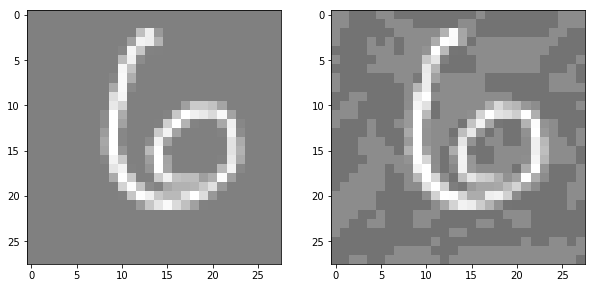

In [162]:
print_before_after_fast_Cmnist(convnet, 100, EPS=0.1)

In [159]:
batch_size = 1
mnist_val_loader = data_utils.DataLoader(mnist_val_dataset, batch_size=batch_size, shuffle=False)

val_opt_accuracy = []
for (i, batch) in tqdm_notebook(enumerate(mnist_val_loader)):  
    if i < 1000:
        noise = attack_optim_mnist(convnet, batch[0], batch[1], target_class = 9 - batch[1].numpy()[0])
        batch[0] = batch[0].squeeze() + noise.squeeze()
        logits = convnet(Variable(torch.FloatTensor(batch[0]).reshape(-1, 1, 28, 28)).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred)
        val_opt_accuracy.append(cur_acc)

noise_target_conv_accuracy = np.mean(val_opt_accuracy)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

# Faces part

In [38]:
people = fetch_lfw_people(min_faces_per_person=10, resize=1)

In [39]:
num_classes = len(people.target_names)
print(num_classes)

158


In [40]:
size = people.data.shape[0]
reshape_data = np.empty((size, 128, 128))

In [44]:
for i in range(size):
    buuffer = transform.resize((people.data[i]/255).reshape(125, 94), (128, 128))
    reshape_data[i] = rgb2gray(buuffer)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [45]:
X_train = reshape_data[:3000].reshape((3000, -1))
print(X_train.shape)
X_val = reshape_data[3000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = reshape_data.shape[1]
image_w = reshape_data.shape[2]

(3000, 16384)
(1324, 16384)


In [46]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

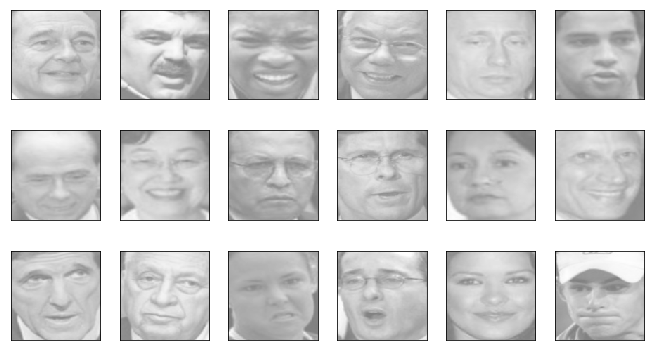

In [47]:
plot_gallery(X_train, image_h, image_w)

In [48]:
batch_size = 100

In [49]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.Tensor(people.target[:3000]))
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.Tensor(people.target[3000:]))
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

### Use pretrained Light CNN-9

In [50]:
from LightCNN import light_cnn
from collections import OrderedDict

In [51]:
model = nn.DataParallel(light_cnn.LightCNN_9Layers(num_classes=79077), device_ids=[0]).cuda()

model.load_state_dict(torch.load('LightCNN_9Layers_checkpoint.pth.tar')['state_dict'])

In [52]:
for params in list(model.parameters())[:-2]:
    params.requires_grad = False

model.module.fc1 = nn.Linear(8192, 256)
model.module.fc2 = nn.Linear(256, num_classes) 

In [53]:
num_epochs = 10
lr = 1e-3

opt = torch.optim.Adam(list(filter(lambda p: p.requires_grad, model.parameters())), lr=lr)
criterion = nn.CrossEntropyLoss()

In [54]:
train_loss = []
val_accuracy = []
model.cuda()

for epoch in range(num_epochs):
    model.train(True)
    for (i_batch, sample_batched) in enumerate(train_loader):
        output, _ = model(Variable(sample_batched[0].reshape(-1, 1, image_h, image_w).cuda()))
        loss = criterion(output, torch.tensor(sample_batched[1], dtype=torch.long).cuda())
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    model.train(False)
    for (i_val_batch, sample_val_batched) in enumerate(val_loader):
        logits, _ = model(Variable(sample_val_batched[0].reshape(-1, 1, image_h, image_w).cuda()))
        y_pred = torch.max(logits, 1)[1].cpu().data.numpy()
        y_true = sample_val_batched[1].cpu().numpy()
        val_accuracy.append(np.mean(y_true == y_pred))
    
    print("epoch = %i" % (epoch + 1))
    print("loss: ", train_loss[-1])
    print("val accuracy: ", val_accuracy[-1])

validation_light = np.mean(val_accuracy[-1])

epoch = 1
('loss: ', array(2.7841570377349854, dtype=float32))
('val accuracy: ', 0.75)
epoch = 2
('loss: ', array(0.37831807136535645, dtype=float32))
('val accuracy: ', 0.83333333333333337)
epoch = 3
('loss: ', array(0.014421596191823483, dtype=float32))
('val accuracy: ', 0.91666666666666663)
epoch = 4
('loss: ', array(0.008871631696820259, dtype=float32))
('val accuracy: ', 0.875)
epoch = 5
('loss: ', array(0.008791541680693626, dtype=float32))
('val accuracy: ', 0.875)
epoch = 6
('loss: ', array(0.09783390164375305, dtype=float32))
('val accuracy: ', 0.875)
epoch = 7
('loss: ', array(0.028754625469446182, dtype=float32))
('val accuracy: ', 0.91666666666666663)
epoch = 8
('loss: ', array(0.17409588396549225, dtype=float32))
('val accuracy: ', 0.875)
epoch = 9
('loss: ', array(0.11193451285362244, dtype=float32))
('val accuracy: ', 0.875)
epoch = 10
('loss: ', array(0.013101596385240555, dtype=float32))
('val accuracy: ', 0.91666666666666663)


### Attack Light CNN-9

In [55]:
def compute_loss_attack_light(model, X_batch, y_batch):
    X_batch = torch.tensor(X_batch.reshape(-1, 1, image_h, image_w), requires_grad=True).cuda()
    y_batch = Variable(y_batch.cuda())
    
    logits, _ = model(X_batch)
    
    return F.cross_entropy(logits, y_batch).mean()

In [56]:
def attack_fastgrad_light(model, input_image, target_class, EPS=0.1):
    x = torch.tensor(input_image.reshape(-1, 1, image_h, image_w), requires_grad=True)
    y = torch.tensor([target_class], dtype=torch.long)
    
    initial_prediction, _ = model(x.cuda())
    
    loss = compute_loss_attack_light(model, x, y)
    loss.backward()

    gradient = torch.sign(x.grad.data)
    
    adversarial_example = x.data + EPS * gradient
    adversarial_prediction = model(adversarial_example.cuda())[0].argmax(1).item()
    
    return EPS * gradient

In [57]:
def attack_optim_light(model, input_image, true_class, target_class, max_iter=1000, threshold=10):
    
    par = nn.Parameter(torch.zeros_like(input_image).uniform_())
    optimizer = torch.optim.Adam([par], lr=0.008)

    x = torch.tensor(input_image.reshape(-1, 1, image_h, image_w), requires_grad=True)
    y_target = torch.tensor([target_class], dtype=torch.long)
    y_true = torch.tensor([true_class], dtype=torch.long).cuda()
    initial_prediction = model(x.cuda())[0].argmax(1)
    cur_example = par
    
    for i in range(max_iter):
        optimizer.zero_grad()

        loss= compute_loss_attack_light(model, torch.clamp(x.reshape(-1) + par.reshape(-1), 0, 1), y_target)
        
        regularization = par.pow(2).sum().cuda()

        loss += regularization

        loss.backward()
        optimizer.step()

        adv_prediction = model((x.reshape(-1, 1, image_h, image_w) + 
                                par.reshape(-1, 1, image_h, image_w)).cuda())[0].argmax(1).item()

        if adv_prediction == y_target:
            cur_example = par.data

        if regularization < threshold:
            break
               
    return cur_example

In [58]:
noise_face_accuracy = []
batch_size = 1
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

for EPS in tqdm_notebook(np.arange(0, 0.105, 0.005)):
    val_accuracy = []
    for (i, batch) in enumerate(val_loader):  
        noise = attack_fastgrad_light(model, batch[0], batch[1], EPS = EPS)
        batch[0] = (batch[0].reshape((image_h, image_w)) + noise.squeeze()).reshape(-1)
        logits, _ = model(torch.tensor(batch[0].reshape(-1, 1, image_h, image_w), requires_grad=True).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred)
        val_accuracy.append(cur_acc)

    noise_face_accuracy.append(np.mean(val_accuracy))

HBox(children=(IntProgress(value=0, max=21), HTML(value=u'')))

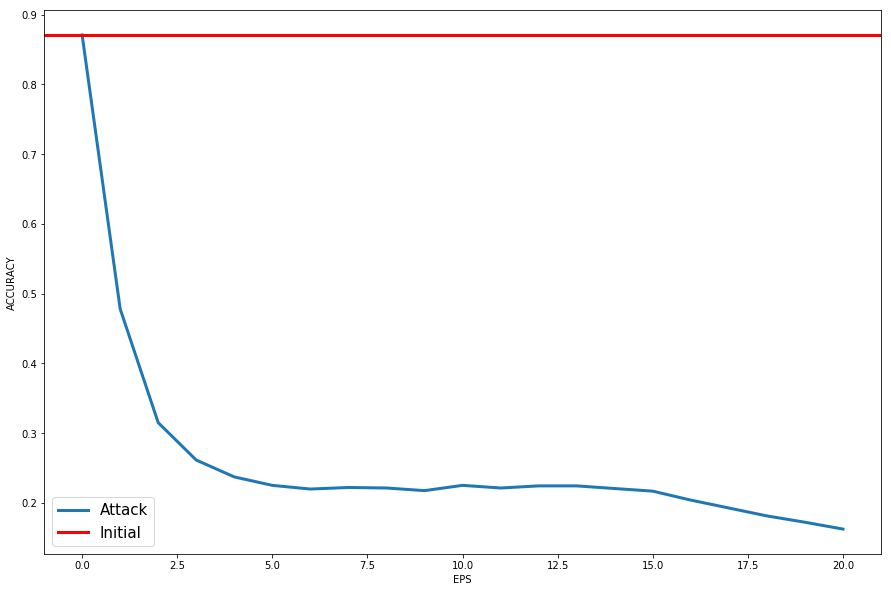

In [59]:
fig = plt.figure(figsize=(15, 10))
plt.plot(noise_face_accuracy, linewidth=3)
plt.axhline(y=noise_face_accuracy[0], color='r', linewidth=3)
plt.legend(["Attack", "Initial"], fontsize = 15)
plt.xlabel("EPS")
plt.ylabel("ACCURACY")
plt.show()

In [60]:
def print_before_after(number, EPS):
    noise = attack_fastgrad_light(model, val[number][0], val[number][1], EPS = EPS).squeeze()
    new_image = val[number][0].reshape((128, 128)) + noise
    
    logits, _ = model(torch.tensor(new_image.reshape(-1, 1, image_h, image_w)).cuda())
    y_pred = logits.argmax(1).cpu().data.numpy()
    
    print "Class before non-targeted attack", int(train[number][1].numpy().item())
    print "Class after non-targeted attack", y_pred[0]
    print "Epsilon is", EPS
    
    fig = plt.figure(figsize=(10, 15))
    plt.subplot(121)
    plt.imshow(val[number][0].reshape((image_h, image_w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.subplot(122)
    plt.imshow(new_image.reshape((image_h, image_w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.show()

Class before non-targeted attack 134
Class after non-targeted attack 4
Epsilon is 0.01


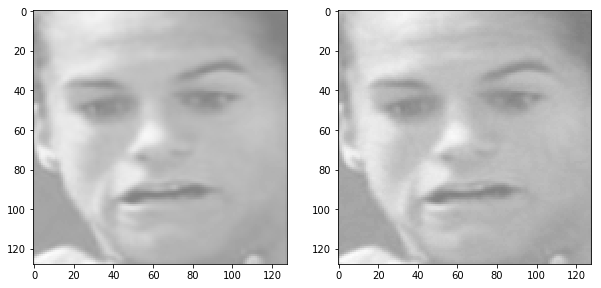

In [76]:
print_before_after(254, 0.01)

In [84]:
batch_size = 1
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

val_accuracy = []
for (i, batch) in tqdm_notebook(enumerate(val_loader)):  
    if i < 100:
        noise = attack_optim_light(model, batch[0], batch[1], num_classes - batch[1], max_iter = 100)
        batch[0] = (batch[0].reshape(-1) + noise.reshape(-1))
        logits, _ = model(torch.tensor(batch[0].reshape(-1, 1, image_h, image_w), requires_grad=True).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred)
        val_accuracy.append(cur_acc)

noise_face_non_accuracy = np.mean(val_accuracy)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [74]:
def print_before_after_target_face(number):
    
    noise = attack_optim_light(model, val[number][0], val[number][1], num_classes - val[number][1]).squeeze()
    new_image = val[number][0] + noise
    logits, _ = model(torch.tensor(new_image.reshape(-1, 1, image_h, image_w)).cuda())
    y_pred = logits.argmax(1).cpu().data.numpy()
    
    print "Class before targeted attack", int(train[number][1].numpy().item())
    print "Class after targeted attack", y_pred[0]
    print "Epsilon is", 1
    
    fig = plt.figure(figsize=(10, 15))
    plt.subplot(121)
    plt.imshow(val[number][0].reshape((image_h, image_w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.subplot(122)
    plt.imshow(new_image.reshape((image_h, image_w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    plt.show()

Class before targeted attack 134
Class after targeted attack 154
Epsilon is 1


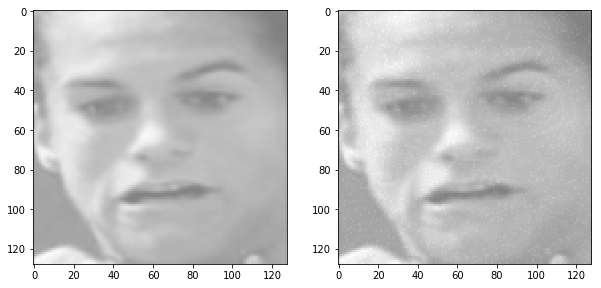

In [75]:
print_before_after_target_face(254)

## Light CNN29

In [77]:
model29 = nn.DataParallel(light_cnn.LightCNN_29Layers(num_classes=79077), device_ids=[0]).cuda()

model29.load_state_dict(torch.load('LightCNN_29Layers_checkpoint.pth.tar')['state_dict'])

In [78]:
for params in list(model29.parameters())[:-4]:
    params.requires_grad = False


model29.module.fc = nn.Linear(8192, 256)
model29.module.fc2 = nn.Linear(256, num_classes) 

In [79]:
num_epochs = 2
lr = 1e-3

opt = torch.optim.Adam(list(filter(lambda p: p.requires_grad, model29.parameters())), lr=lr)
criterion = nn.CrossEntropyLoss()

In [80]:
train_loss = []
val_accuracy = []

model29.cuda()
for epoch in range(num_epochs):
    model.train(True)
    for (i_batch, sample_batched) in enumerate(train_loader):
        output, _ = model29(Variable(sample_batched[0].reshape(-1, 1, image_h, image_w).cuda()))
        loss = criterion(output, torch.tensor(sample_batched[1], dtype=torch.long).cuda())
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    model.train(False)
    for (i_val_batch, sample_val_batched) in enumerate(val_loader):
        logits, _ = model29(Variable(sample_val_batched[0].reshape(-1, 1, image_h, image_w).cuda()))
        y_pred = torch.max(logits, 1)[1].cpu().data.numpy()
        y_true = sample_val_batched[1].cpu().numpy()
        val_accuracy.append(np.mean(y_true == y_pred))
    
    print("epoch = %i" % (epoch + 1))
    print("loss: ", train_loss[-1])
    print("val accuracy: ", val_accuracy[-1])

validation = np.mean(val_accuracy[-1])

epoch = 1
('loss: ', array(2.4431045055389404, dtype=float32))
('val accuracy: ', 1.0)
epoch = 2
('loss: ', array(0.824805736541748, dtype=float32))
('val accuracy: ', 1.0)


In [85]:
noise_light_accuracy = []
batch_size = 1
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

for EPS in tqdm_notebook(np.arange(0, 0.105, 0.005)):
    val_accuracy = []
    for (i, batch) in enumerate(val_loader):  
        noise = attack_fastgrad_light(model29, batch[0], batch[1], EPS = EPS)
        batch[0] = (batch[0].reshape((128, 128)) + noise.squeeze()).reshape(-1)
        logits, _ = model29(torch.tensor(batch[0].reshape(-1, 1, image_h, image_w), requires_grad=True).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred)
        val_accuracy.append(cur_acc)

    noise_light_accuracy.append(np.mean(val_accuracy))

HBox(children=(IntProgress(value=0, max=21), HTML(value=u'')))

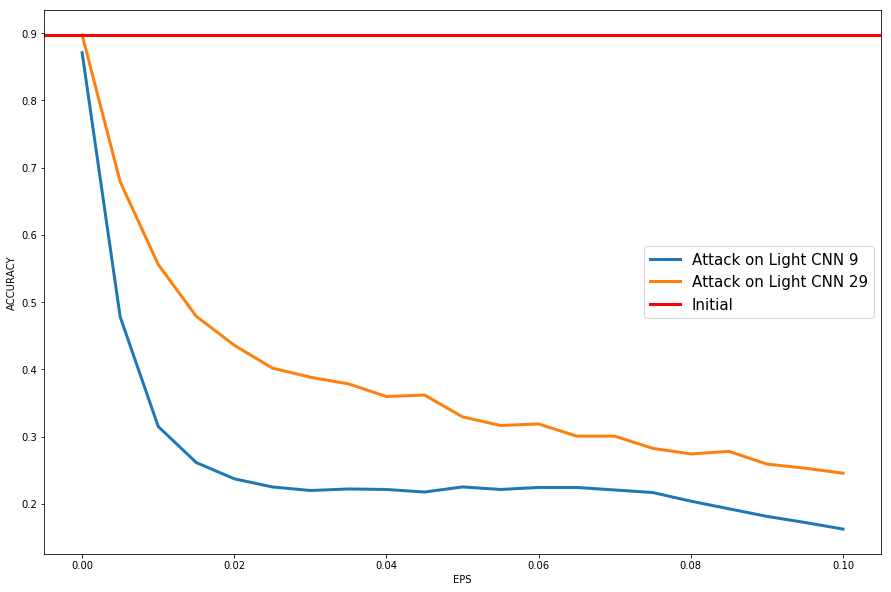

In [86]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 0.105, 0.005), noise_face_accuracy, linewidth=3)
plt.plot(np.arange(0, 0.105, 0.005), noise_light_accuracy, linewidth=3)
plt.axhline(y=noise_light_accuracy[0], color='r', linewidth=3)
plt.legend(["Attack on Light CNN 9", "Attack on Light CNN 29", "Initial"], fontsize = 15)
plt.xlabel("EPS")
plt.ylabel("ACCURACY")
plt.show()

In [88]:
noise_light_accuracy[-1]

0.24546827794561935

Class before non-targeted attack 11
Class after non-targeted attack 61
Epsilon is 0.004


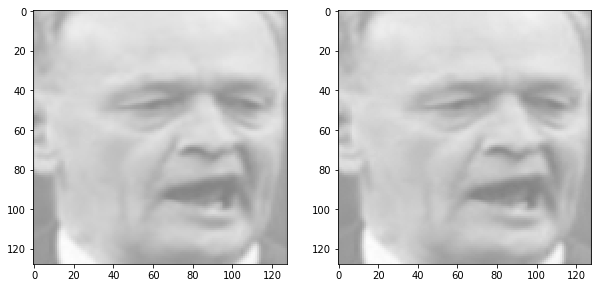

In [74]:
print_before_after(13, 0.004)

In [75]:
batch_size = 1
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

val_accuracy = []
for (i, batch) in tqdm_notebook(enumerate(val_loader)):  
    if i < 100:
        noise = attack_optim_light(model29, batch[0], batch[1], num_classes - batch[1], max_iter = 100)
        batch[0] = (batch[0].reshape(-1) + noise.reshape(-1))
        logits, _ = model29(torch.tensor(batch[0].reshape(-1, 1, image_h, image_w), requires_grad=True).cuda())
        y_pred = logits.argmax(1).cpu().data.numpy()
        y_batch = batch[1].cpu().numpy()  
        cur_acc = (y_batch == y_pred)
        val_accuracy.append(cur_acc)

noise_face_tar_accuracy = np.mean(val_accuracy)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))